In [0]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [0]:
import os
os.chdir('/drive/My Drive/DSTA AI Comp/W.A.S.D Warriors')

In [0]:
import os

base_dir = 'data/trainset_11classes_0_00000'

# Directory to our training data
train_folder = os.path.join(base_dir, 'train_new_combined')

# Directory to our validation data
val_folder = os.path.join(base_dir, 'val')

In [0]:
# List folders and number of files
print("Directory, Number of files")
for root, subdirs, files in os.walk(base_dir):
    print(root, len(files))

Directory, Number of files
data/trainset_11classes_0_00000 1
data/trainset_11classes_0_00000/val 0
data/trainset_11classes_0_00000/val/ChairPose 23
data/trainset_11classes_0_00000/val/Dabbing 23
data/trainset_11classes_0_00000/val/HandGun 26
data/trainset_11classes_0_00000/val/ChildPose 22
data/trainset_11classes_0_00000/val/Salute 24
data/trainset_11classes_0_00000/val/HulkSmash 24
data/trainset_11classes_0_00000/val/KoreanHeart 22
data/trainset_11classes_0_00000/val/KungfuSalute 25
data/trainset_11classes_0_00000/val/KungfuCrane 21
data/trainset_11classes_0_00000/val/WarriorPose 22
data/trainset_11classes_0_00000/val/HandShake 21
data/trainset_11classes_0_00000/val/ChestBump 17
data/trainset_11classes_0_00000/val/EaglePose 27
data/trainset_11classes_0_00000/val/HighKneel 24
data/trainset_11classes_0_00000/val/Spiderman 26
data/trainset_11classes_0_00000/train 0
data/trainset_11classes_0_00000/train/HandShake 83
data/trainset_11classes_0_00000/train/HandGun 93
data/trainset_11classes_

In [0]:
model_list = ['XcepFT_for_ensemble', 'DenseFT_for_ensemble']

In [0]:
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.layers.merge import concatenate
from keras import regularizers
from numpy import argmax
import time

dp = 0.5
reg = 1e-2

num_classes = 15

# load models from file
def load_all_models(model_list):
  all_models = list()
  for index, i in enumerate(model_list):
    print('Loading model %i of %i: %s...' % (index+1, len(model_list), i))
    # define filename for this ensemble
    filename = i + '.hdf5'
    # load model from file
    st = time.time()
    try:
      model = load_model(filename)
    except Exception as error:
      print(error)
    # add to list of members
    all_models.append(model)
    print('>loaded %s' % filename)
    print('>>time taken: %.3f s' % (time.time()-st))
  print('Complete!')
  return all_models
 
# define stacked model from multiple member input models
def define_stacked_model(members):
  # update all layers in all models to not be trainable
  for i in range(len(members)):
    model = members[i]
    for layer in model.layers:
      # make not trainable
      layer.trainable = False
      # rename to avoid 'unique layer name' issue
      layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
  # define multi-headed input
  ensemble_visible = [model.input for model in members]
  #ensemble_visible = members[0].input
  # concatenate merge output from each model
  ensemble_outputs = [model.output for model in members]
  merge = concatenate(ensemble_outputs)
  hidden1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg))(merge)
  dropout1 = Dropout(dp)(hidden1)
  hidden2 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(reg))(dropout1)
  dropout2 = Dropout(dp)(hidden2)
  output = Dense(num_classes, activation='softmax')(dropout2)
  model = Model(inputs=ensemble_visible, outputs=output)
  # plot graph of ensemble
  #plot_model(model, show_shapes=True, to_file='model_graph.png')
  # compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
 
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
  # prepare input data
  X = [inputX for _ in range(len(model.input))]
  # encode output data
  inputy_enc = to_categorical(inputy)
  # fit model
  model.fit(X, inputy_enc, epochs=300, verbose=0)
 
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
  # prepare input data
  X = [inputX for _ in range(len(model.input))]
  # make prediction
  return model.predict(X, verbose=0)
 

In [0]:
all_models = load_all_models(model_list)

Loading model 1 of 2: XcepFT_for_ensemble...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
>loaded XcepFT_for_ensemble.hdf5
>>time taken: 15.327 s
Loading model 2 of 2: DenseFT_for_ensemble...
>loaded DenseFT_for_ensemble.hdf5
>>time taken: 50.040 s
Complete!


In [0]:
model = define_stacked_model(all_models)

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ensemble_2_input_1 (InputLayer) (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
ensemble_2_zero_padding2d_1 (Ze (None, 305, 305, 3)  0           ensemble_2_input_1[0][0]         
__________________________________________________________________________________________________
ensemble_2_conv1/conv (Conv2D)  (None, 150, 150, 64) 9408        ensemble_2_zero_padding2d_1[0][0]
__________________________________________________________________________________________________
ensemble_2_conv1/bn (BatchNorma (None, 150, 150, 64) 256         ensemble_2_conv1/conv[0][0]      
__________________________________________________________________________________________________
ensemble_2

In [0]:
import numpy as np

def get_random_eraser(p=0.75, s_l=0.02, s_h=0.1, r_1=0.1, r_2=1/0.1, v_l=0, v_h=1, pixel_level=True):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Batch size
bs = 64

# Number of models to ensemble
num_models = len(model_list)

# All images will be resized to this value
image_size = (299, 299)

# All images will be rescaled by 1./255. We apply data augmentation here.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   brightness_range= [0.4,1.6],
                                   horizontal_flip=True,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   rotation_range=50,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

def generate_generator_multiple(generator, num_model, directory, bs, image_size):
  generator1 = generator.flow_from_directory(
      directory= directory, # This is the source directory for training images 
      target_size=image_size, # All images will be resized to value set in image_size
      batch_size=bs,
      class_mode='categorical')
  
  while True:
    generator = generator1.next()
    x_input = []
    
    for i in range(num_model):
      x_input.append(generator[0])
    
    y_input = generator[1]
    
    yield x_input, y_input  #Yield both images and their mutual label

# Flow training images in batches of 32 using train_datagen generator
print("Preparing generator for train dataset")
train_generator = generate_generator_multiple(train_datagen, num_models, train_folder, bs, image_size)

# Flow validation images in batches of 32 using val_datagen generator
print("Preparing generator for validation dataset")
val_generator = generate_generator_multiple(val_datagen, num_models, val_folder, bs, image_size)

Preparing generator for train dataset
Preparing generator for validation dataset


In [0]:
from keras.callbacks import ModelCheckpoint

bestValidationCheckpointer = ModelCheckpoint('15class_ensemble_model.hdf5', monitor='val_acc', save_best_only=True, verbose=1)

In [0]:
history = model.fit_generator(
        train_generator, # train generator has 973 train images
        steps_per_epoch=1441//bs+1, #train_generator.samples // bs + 1,
        epochs=100,
        validation_data=val_generator, # validation generator has 253 validation images
        validation_steps=347//bs+1, #val_generator.samples // bs + 1,
        callbacks=[bestValidationCheckpointer],
)

Epoch 1/100
23/23 [==============================] - 117s 5s/step - loss: 4.0038 - acc: 0.1184 - val_loss: 3.8865 - val_acc: 0.3084

Epoch 00001: val_acc improved from -inf to 0.30836, saving model to 15class_ensemble_model.hdf5
Epoch 2/100
23/23 [==============================] - 60s 3s/step - loss: 3.8083 - acc: 0.2103 - val_loss: 3.7074 - val_acc: 0.5159

Epoch 00002: val_acc improved from 0.30836 to 0.51585, saving model to 15class_ensemble_model.hdf5
Epoch 3/100
23/23 [==============================] - 102s 4s/step - loss: 3.6363 - acc: 0.2910 - val_loss: 3.5347 - val_acc: 0.5879

Epoch 00003: val_acc improved from 0.51585 to 0.58790, saving model to 15class_ensemble_model.hdf5
Epoch 4/100
23/23 [==============================] - 98s 4s/step - loss: 3.4415 - acc: 0.3777 - val_loss: 3.3585 - val_acc: 0.6254

Epoch 00004: val_acc improved from 0.58790 to 0.62536, saving model to 15class_ensemble_model.hdf5
Epoch 5/100
23/23 [==============================] - 99s 4s/step - loss: 3.26

KeyboardInterrupt: ignored

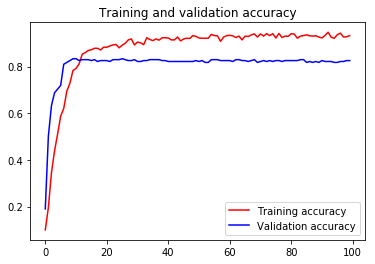

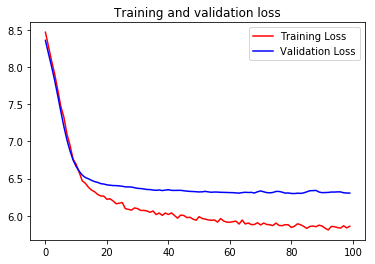

In [0]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()